<a href="https://colab.research.google.com/github/Gauravkumarlokhande/neural_network_scratch/blob/main/Load_and_process_data_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import glob

In [ ]:
os.getcwd()

'/content'

Downloading the dataset in the tgz format

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# Define the cache directory and the filename
cache_dir = '/content'  # This will create a 'dataset' folder in your current working directory
  # Name of the folder to save the dataset

# Download and extract the dataset
archive = tf.keras.utils.get_file(origin=dataset_url, untar=True, cache_dir=cache_dir)
# Get the path to the extracted directory
data_dir = pathlib.Path(archive)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
img_dir='/content/datasets/flowers/flower_photos'

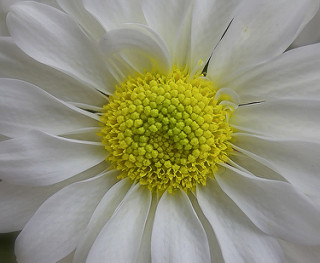

In [ ]:
PIL.Image.open('/content/datasets/flowers/flower_photos/daisy/100080576_f52e8ee070_n.jpg')

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
# splitting the data into train test validate, 20% is the validation set

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


Another way to load dataset

In [ ]:
image_count=20
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
  print(f.numpy())

b'/content/datasets/flower_photos.tgz/flower_photos/sunflowers'
b'/content/datasets/flower_photos.tgz/flower_photos/roses'
b'/content/datasets/flower_photos.tgz/flower_photos/LICENSE.txt'
b'/content/datasets/flower_photos.tgz/flower_photos/dandelion'
b'/content/datasets/flower_photos.tgz/flower_photos/tulips'


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Though both the codes above are same but for train ds the data is getting split into 80% for training because the subset parameter is set to training. and in the second code the subset parameter is set to validation hence the data splits into 20% for validation set.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


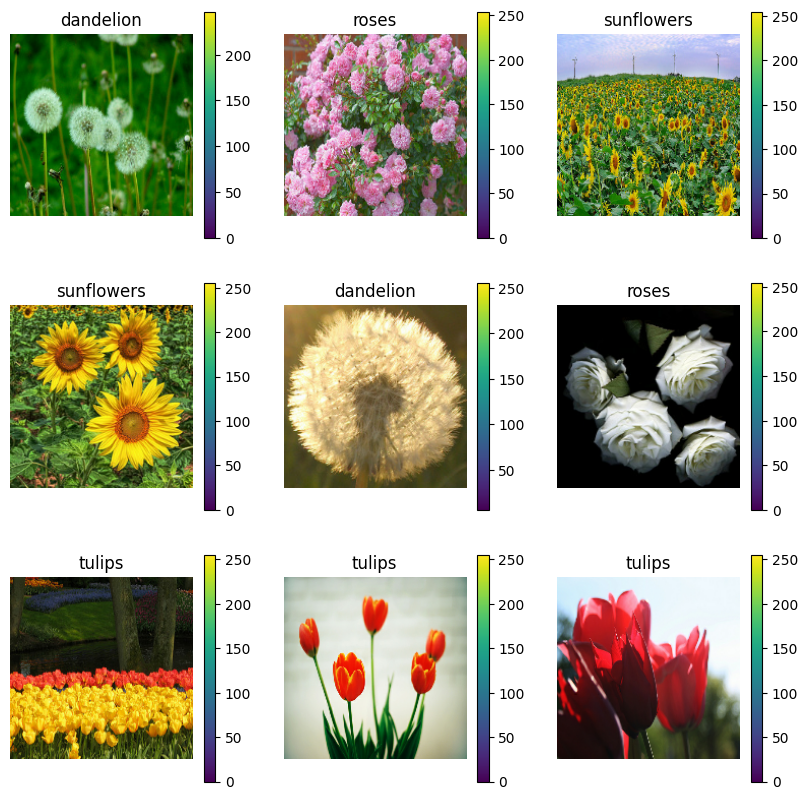

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.colorbar()

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. as visualized in the colour bar

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

Scaling can be done in two ways, either by using data.map or by specifying the resizing layer into the model. Using the second method to specify the resizing layer in the model

**Dataset.cache:** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
**Dataset.prefetch:** overlaps data preprocessing and model execution while training.


. cache():

What It Does: The cache() function stores the dataset in memory (or on disk) after the first epoch, so subsequent epochs can access the data quickly without reloading it from the original source.​

Why It's Needed: Loading data from disk can be time-consuming. By caching the dataset, you eliminate the need to reload data in each epoch, thus speeding up training.​

When to Use: It's particularly useful when your dataset is small enough to fit into memory. However, if the dataset is too large, caching might consume too much memory, leading to potential issues.​

2. prefetch():

What It Does: The prefetch() function allows the data loading process to run in parallel with model training. While the model is processing the current batch, prefetch() prepares the next batch.​

Why It's Needed: Without prefetching, the model might have to wait for the next batch to be loaded before continuing training, leading to idle time. Prefetching ensures that data is always ready for the model, keeping it busy and reducing training time.​

When to Use: It's beneficial in almost all training scenarios, especially when data loading and preprocessing take a significant amount of time.​

In TensorFlow, tf.data.AUTOTUNE is a setting that allows TensorFlow to automatically determine the optimal number of batches to prefetch during model training. This helps in overlapping data preprocessing and model execution, leading to more efficient training.​

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 5
# defining the model
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(23, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.3044 - loss: 1.5228 - val_accuracy: 0.5804 - val_loss: 1.0934
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5582 - loss: 1.0656 - val_accuracy: 0.5490 - val_loss: 1.1055
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6250 - loss: 0.9258 - val_accuracy: 0.5613 - val_loss: 1.0991
